# Cell counting

#####  Preparing data, saving as arrays

In [74]:
import os
import cv2
import numpy as np
import csv
import matplotlib.pyplot as plt
import pickle # for saving/loading data from binary
from PIL import Image

#Constants
IMAGE_FOLDER="F:\BSU_FAMCS\BMI\CourseProject\Datasets\ATiles"
IMG_SIZE=256
IMG_SIZEresidual=224

def prepare_data(csv_fileName):
    X=[]
    Y=[]
    data=[]
    
    file=open(os.path.join(IMAGE_FOLDER,csv_fileName),"r")
    reader=csv.reader(file,delimiter=',')
        
    for row in reader: 
        img_array=cv2.imread(os.path.join(IMAGE_FOLDER,row[6]))
        #img_array=cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        new_array=cv2.resize(img_array,(IMG_SIZEresidual,IMG_SIZEresidual),interpolation=cv2.INTER_AREA)
            
        brown=row[8]
        blue=row[9]
        
    
        #X.append(new_array)
        #Y.append(float(brown))
        
        #data.append([new_array,float(brown)])
            
        if float(brown)>=4:
            data.append([new_array,float(brown),float(blue)])
            #DATA AUGMENTATION
            data.append([np.flip(new_array,0),float(brown),float(blue)])
            data.append([np.flip(new_array,1),float(brown),float(blue)])
            data.append([np.flip(new_array),float(brown),float(blue)])
            print(float(brown),float(blue),float(blue))
        else:
            if np.random.uniform(0,1)>0.4:
                data.append([new_array,float(brown),float(blue)])
                
                
    Yblue=[]    
    #SHUFFLE and separation
    np.random.shuffle(data)
    for arr in data:
        X.append(arr[0])
        Y.append(arr[1])
        Yblue.append(arr[2])
        
            
    #Reshaping and Normalization
    X=np.array(X).reshape(-1,IMG_SIZEresidual,IMG_SIZEresidual,3)
    X=X/255.0
    Y=np.array(Y).reshape(-1,1) # we have to return 2 values: brown and blue quantities
    Y=Y.astype(np.float) 
    Y=Y/65.0
    
    Yblue=np.array(Yblue).reshape(-1,1)
    Yblue=Yblue.astype(np.float)
    
    return X,Y,Yblue  


def pickling_out(X,name):
    """Saving X in binary file "name".pickle"""
    pickle_out=open("{}.pickle".format(name),"wb")
    pickle.dump(X,pickle_out)
    pickle_out.close()
    
    
def pickling_in(name):
    """Loading X from binary file "name".pickle"""
    pickle_in=open("{}.pickle".format(name),"rb")
    X=pickle.load(pickle_in)
    pickle_in.close()
    return X
    

In [75]:
trainX,trainY,trainYblue=prepare_data("bb_tiles_DATASET.csv")

10.5 58.0 58.0
4.5 56.0 56.0
10.0 49.0 49.0
9.5 43.0 43.0
8.5 11.0 11.0
6.5 37.0 37.0
23.0 22.0 22.0
20.5 19.5 19.5
7.1 65.0 65.0
27.0 31.0 31.0
6.0 44.0 44.0
14.0 59.0 59.0
61.0 9.0 9.0
5.2 19.0 19.0
16.0 24.0 24.0
35.0 7.0 7.0
17.0 26.0 26.0
7.0 43.0 43.0
6.0 11.0 11.0
33.0 23.0 23.0
9.5 74.0 74.0
27.5 15.0 15.0
21.0 35.0 35.0
42.0 20.0 20.0
52.0 30.0 30.0
6.5 52.0 52.0
9.0 14.0 14.0
49.0 3.0 3.0
34.0 9.0 9.0
21.0 32.0 32.0
9.0 19.0 19.0
9.2 22.0 22.0
24.0 34.0 34.0
8.5 52.0 52.0
10.0 35.0 35.0
39.0 12.0 12.0
8.0 14.0 14.0
4.5 20.0 20.0
19.0 13.0 13.0
7.0 39.0 39.0
31.0 13.0 13.0
11.0 35.0 35.0
18.0 2.0 2.0
44.0 22.0 22.0
17.5 21.0 21.0
18.5 11.0 11.0
6.0 35.0 35.0
12.0 18.0 18.0
30.0 15.0 15.0
7.5 37.0 37.0
54.0 1.0 1.0
4.5 38.0 38.0
41.0 7.0 7.0
19.0 48.0 48.0
52.0 1.0 1.0
5.0 11.0 11.0
27.0 8.0 8.0
22.0 24.0 24.0
4.0 45.0 45.0
7.0 6.0 6.0
6.0 40.0 40.0
17.0 11.0 11.0
32.0 23.0 23.0


In [76]:
#Saving prepared data
pickling_out(trainX[:260],os.path.join(IMAGE_FOLDER,"trainX"))
pickling_out(trainY[:260],os.path.join(IMAGE_FOLDER,"trainYbrown"))
pickling_out(trainYblue[:260],os.path.join(IMAGE_FOLDER,"trainYblue"))


pickling_out(trainX[260:],os.path.join(IMAGE_FOLDER,"testX"))
pickling_out(trainY[260:],os.path.join(IMAGE_FOLDER,"testYbrown"))
pickling_out(trainYblue[260:],os.path.join(IMAGE_FOLDER,"testYblue"))

In [77]:
trainX[:,:,:,[0,1,2]]=trainX[:,:,:,[2,1,0]]

In [80]:
len(trainX)

301

##### Loading binary data

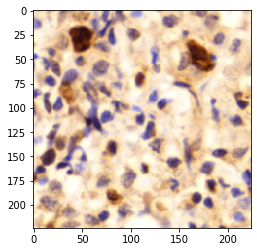

In [52]:
trainX=pickling_in(os.path.join(IMAGE_FOLDER,"trainX"))
trainY=pickling_in(os.path.join(IMAGE_FOLDER,"trainY"))  

testX=pickling_in(os.path.join(IMAGE_FOLDER,"testX"))
testY=pickling_in(os.path.join(IMAGE_FOLDER,"testY"))
plt.imshow(trainX[10])

## Neural network model

In [6]:
import tqdm
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

NAME="SimpleCNN5"

#______MODEL_______
model=keras.models.Sequential() 

#_____Convolutional layers
model.add(Conv2D(32,(3,3),input_shape=trainX.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

#_____Flattening
model.add(Flatten()) # convert to 1D vector

#_____Dense layers
model.add(Dense(64))
model.add(Activation("relu"))

#_____Dropout
model.add(Dropout(0.5))

model.add(Dense(32))
model.add(Activation("relu"))

model.add(Dense(16))
model.add(Activation("relu"))

#_____Output layer
model.add(Dense(1))
model.add(Activation("linear"))


#Tensorboard
tensorboard=TensorBoard(log_dir="logs\{}".format(NAME))

optim = tf.keras.optimizers.RMSprop(0.001)
#COMPILE
model.compile(loss="mse",
              optimizer=optim,
              metrics=["mae","mse"])

#FIT
model.fit(trainX,trainY,
         batch_size=16,
         epochs=11,
         validation_split=0.2,
         callbacks=[tensorboard],
         )

c:\python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Train on 104 samples, validate on 26 samples
Epoch 1/11
104/104 [==============================] - ETA: 25s - loss: 597.9848 - mae: 20.8062 - mse: 597.984 - ETA: 13s - loss: 1246610.2424 - mae: 676.9565 - mse: 1246610.25 - ETA: 8s - loss: 897787.6929 - mae: 557.3069 - mse: 897787.6875   - ETA: 5s - loss: 676529.5577 - mae: 440.3316 - mse: 676529.562 - ETA: 3s - loss: 542298.7895 - mae: 364.3922 - mse: 542298.812 - ETA: 0s - loss: 452854.4384 - mae: 313.9845 - mse: 452854.468 - 13s 125ms/sample - loss: 418086.3180 - mae: 291.8446 - mse: 418086.3438 - val_loss: 511.8784 - val_mae: 21.0201 - val_mse: 511.8784
Epoch 2/11
104/104 [==============================] - ETA: 5s - loss: 771.0800 - mae: 22.2856 - mse: 771.08 - ETA: 4s - loss: 569.7805 - mae: 17.8442 - mse: 569.78 - ETA: 4s - loss: 562.6181 - mae: 18.4450 - mse: 562.61 - ETA: 3s - loss: 472.2120 - mae: 16.5508 - mse: 472.21 - ETA: 1s - loss: 449.6402 - mae: 15.3566 - mse: 449.64 - ETA: 0s - loss: 398.2194 - mae: 14.5163 - mse: 398.2

In [182]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11712), started 0:09:10 ago. (Use '!kill 11712' to kill it.)

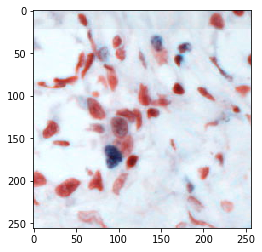

In [165]:
image_predict=cv2.imread(os.path.join(IMAGE_FOLDER,"1171401.png"),cv2.IMREAD_COLOR)
plt.imshow(image_predict)
plt.show()

In [9]:
predicted=model.predict(testX)

TypeError: Value passed to parameter 'input' has DataType uint8 not in list of allowed values: float16, bfloat16, float32, float64

In [8]:
predicted=predicted.tolist()
testY=testY.tolist()

NameError: name 'predicted' is not defined

In [237]:
table=[]
for value in range(11):
    table.append([predicted[0][value],testY[0][value]])

In [251]:
import pandas as pd
temp=pd.DataFrame(data=table,columns=["predicted","real"])
pd.set_option('display.max_rows', len(temp))
print(temp)
pd.reset_option('display.max_rows')


    predicted  real
0    5.381755   7.0
1    4.213250   6.0
2    4.211274   0.0
3    4.141817   0.0
4    4.275476   3.5
5    3.798824   1.0
6    9.353242  17.0
7    3.806925   0.0
8    3.555959   0.0
9   42.388237  32.0
10   3.589563   0.0


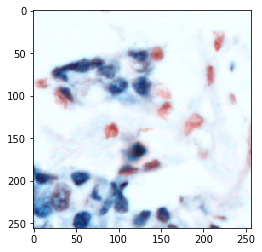

In [206]:
plt.imshow(testX[6])
plt.show()

In [198]:
testY

array([[ 7. ],
       [ 6. ],
       [ 0. ],
       [ 0. ],
       [ 3.5],
       [ 1. ],
       [17. ],
       [ 0. ],
       [ 0. ],
       [32. ],
       [ 0. ]])

In [187]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
activation_77 (Activation)   (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
activation_78 (Activation)   (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 60, 60, 128)     

In [7]:
test_predictions = model.predict(trainX).flatten()

plt.scatter(trainY, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

TypeError: Value passed to parameter 'input' has DataType uint8 not in list of allowed values: float16, bfloat16, float32, float64

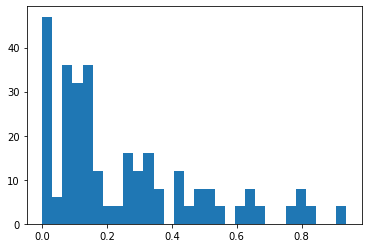

In [12]:
plt.hist(trainY,bins=30)#REAL Quantity of BROWN
plt.show()

In [4]:
train_predicted=model.predict(trainX) #PREDICTED HIST
plt.hist(train_predicted,bins=30)
plt.show()

NameError: name 'model' is not defined